# Occupancy Grid PseudoCode

We first need to convert the actor_state_tensor to a more usable format, the information that we need should be stored into a dictionary like this:
```
{
    walls: [
        {pos_x: 0,
        pos_y: 0,
        width: 1,
        height: 10,
        theta: 0}, 
        ...
    ], 
    obstacles: [
        {pos_x: 0,
        pos_y: 0,
        width: 1,
        height: 1,
        theta: 0.32},
        ...
    ]
    robot: [
        {pos_x: 0, 
        pos_y: 0,
        width: 1, 
        height: 1, 
        theta: 2.5}
    ]
}
```

Given an object's `pos_x`, `pos_y`, `width`, `height`, the upper and lower bound space that the object occupies is:

x: [`pos_x` + `width`/2, `pos_x` - `width`/2] if orientation == 0 else  [`pos_x` + `height`/2, `pos_x` - `height`/2]

y: [`pos_y` + `height`/2, `pos_y` - `height`/2] if orientation == 0 else [`pos_y` + `width`/2, `pos_y` - `width`/2]

Let's assume that every room is the same dimension, and the occupancy grid represents a 10m x 10m space with a n x n grid

In this space we represent each cell with the following notation:
- 0: free space
- 1: wall
- 2: obstacle
- 3: robot

> Let's approach from the perspective that each object needs to be represented on the grid:

### Naive approach:
All cells that the x-y bound of the obstacle touches (with threshold > 25% of the grid?) will belong to this object;

Where there multiple objects negotiating for a single cell, we choose the object with the largest area present

should work if object size << grid size



### Approach with parameter $\theta$

Given an object's `pos_x`, `pos_y`, `width`, `height`, `theta`, we can derive the following four lines bounding the rectangular object:

"top" and "bottom" bounds:
$$
y = -\frac{1}{\tan(\theta)}x \pm \frac{h}{2}\frac{1}{\cos(\theta)}
$$

"right" and "left" bounds:
$$
y = \tan(\theta)x \pm \frac{w}{2}\frac{1}{\sin(\theta)}
$$

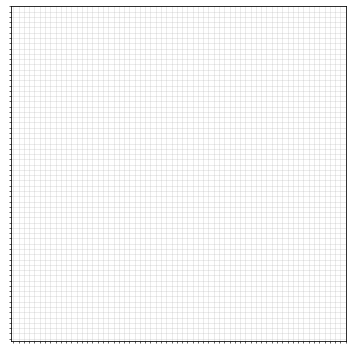

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

# show empty grid of n x n
n = 64

occ_grid = torch.zeros((n, n))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ticks = np.linspace(0.5, n-0.5, n)
ax.set_xticks(ticks, minor=True)
ax.set_yticks(ticks, minor=True)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.grid(which='minor', alpha=0.3)

# ax.imshow(occ_grid)
plt.tight_layout()



In [123]:
# num_envs = 3
# num_walls = 4

# # define the walls
# walls = torch.tensor([[-1.6+5, 0+5, 8, 0.2, np.pi/2],
#                       [1.6+5, 0+5, 8, 0.2, np.pi/2],
#                       [0+5, 4+5, 3.2, 0.2, 0],
#                       [0+5, -4+5, 3.2, 0.2, 0],
#                       ]).unsqueeze(0).repeat(num_envs, 1, 1)
# # walls = torch.tensor([[-1.6+5, 0+5, 8, 0.2, np.pi/2]
# #                       ]).unsqueeze(0).repeat(num_envs, 1, 1)
# walls_vertices = torch.zeros(num_envs, num_walls, 4, 2)

# # ================================================================================

# room_size = 10
# n = 64

# w = walls[:, :, 2] * (n/room_size)
# h = walls[:, :, 3] * (n/room_size)
# d = ((w/2)**2 + (h/2)**2)**0.5

# # only these need to be updated - object shape doesn't change
# x_pos = walls[:, :, 0] * (n/room_size)
# y_pos = walls[:, :, 1] * (n/room_size)
# theta = walls[:, :, 4]

# a = np.sin(np.arctan(w/h) + theta) * d + x_pos
# print(a.shape)
# walls_vertices[:, :, 0, 0] = np.sin(np.arctan(w/h) + theta) * d + x_pos
# walls_vertices[:, :, 0, 1] = np.cos(np.arctan(w/h) + theta) * d + y_pos
# walls_vertices[:, :, 1, 0] = np.sin(np.pi - np.arctan(w/h) + theta) * d + x_pos
# walls_vertices[:, :, 1, 1] = np.cos(np.pi - np.arctan(w/h) + theta) * d + y_pos
# walls_vertices[:, :, 2, 0] = np.sin(np.pi + np.arctan(w/h) + theta) * d + x_pos
# walls_vertices[:, :, 2, 1] = np.cos(np.pi + np.arctan(w/h) + theta) * d + y_pos
# walls_vertices[:, :, 3, 0] = np.sin(-np.arctan(w/h) + theta) * d + x_pos
# walls_vertices[:, :, 3, 1] = np.cos(-np.arctan(w/h) + theta) * d + y_pos

# rotated_wall_vertices = torch.zeros_like(walls_vertices)
# rotated_wall_vertices[:, :, 1, :] = walls_vertices[:, :, 0, :]
# rotated_wall_vertices[:, :, 2, :] = walls_vertices[:, :, 1, :]
# rotated_wall_vertices[:, :, 3, :] = walls_vertices[:, :, 2, :]
# rotated_wall_vertices[:, :, 0, :] = walls_vertices[:, :, 3, :]

# walls_vertices = torch.flatten(walls_vertices, start_dim=1, end_dim=2)
# rotated_wall_vertices = torch.flatten(
#     rotated_wall_vertices, start_dim=1, end_dim=2)


torch.Size([3, 4])
torch.Size([3, 4, 4, 2])
torch.Size([3, 16, 2])


In [128]:
num_envs = 3
num_walls = 4
walls = torch.tensor([[-1.6+5, 0+5, 8, 0.2, np.pi/2],
                      [1.6+5, 0+5, 8, 0.2, np.pi/2],
                      [0+5, 4+5, 3.2, 0.2, 0],
                      [0+5, -4+5, 3.2, 0.2, 0],
                      ]).unsqueeze(0).repeat(num_envs, 1, 1)
walls_vertices = torch.zeros(num_envs, num_walls, 4, 2)
rotated_walls_vertices = torch.zeros_like(walls_vertices)


def get_vertices(obj_state, obj_vertices, obj_rot_vertices, room_size=10, n=64):
    w = obj_state[:, :, 2] * (n/room_size)
    h = obj_state[:, :, 3] * (n/room_size)
    d = ((w/2)**2 + (h/2)**2)**0.5

    # only these need to be updated - object shape doesn't change
    x_pos = obj_state[:, :, 0] * (n/room_size)
    y_pos = obj_state[:, :, 1] * (n/room_size)
    theta = obj_state[:, :, 4]

    obj_vertices[:, :, 0, 0] = np.sin(np.arctan(w/h) + theta) * d + x_pos
    obj_vertices[:, :, 0, 1] = np.cos(np.arctan(w/h) + theta) * d + y_pos
    obj_vertices[:, :, 1, 0] = np.sin(
        np.pi - np.arctan(w/h) + theta) * d + x_pos
    obj_vertices[:, :, 1, 1] = np.cos(
        np.pi - np.arctan(w/h) + theta) * d + y_pos
    obj_vertices[:, :, 2, 0] = np.sin(
        np.pi + np.arctan(w/h) + theta) * d + x_pos
    obj_vertices[:, :, 2, 1] = np.cos(
        np.pi + np.arctan(w/h) + theta) * d + y_pos
    obj_vertices[:, :, 3, 0] = np.sin(-np.arctan(w/h) + theta) * d + x_pos
    obj_vertices[:, :, 3, 1] = np.cos(-np.arctan(w/h) + theta) * d + y_pos

    obj_rot_vertices[:, :, 1, :] = obj_vertices[:, :, 0, :]
    obj_rot_vertices[:, :, 2, :] = obj_vertices[:, :, 1, :]
    obj_rot_vertices[:, :, 3, :] = obj_vertices[:, :, 2, :]
    obj_rot_vertices[:, :, 0, :] = obj_vertices[:, :, 3, :]

    return obj_vertices, obj_rot_vertices


walls_vertices, rotated_walls_vertices = get_vertices(
    walls, walls_vertices, rotated_walls_vertices)


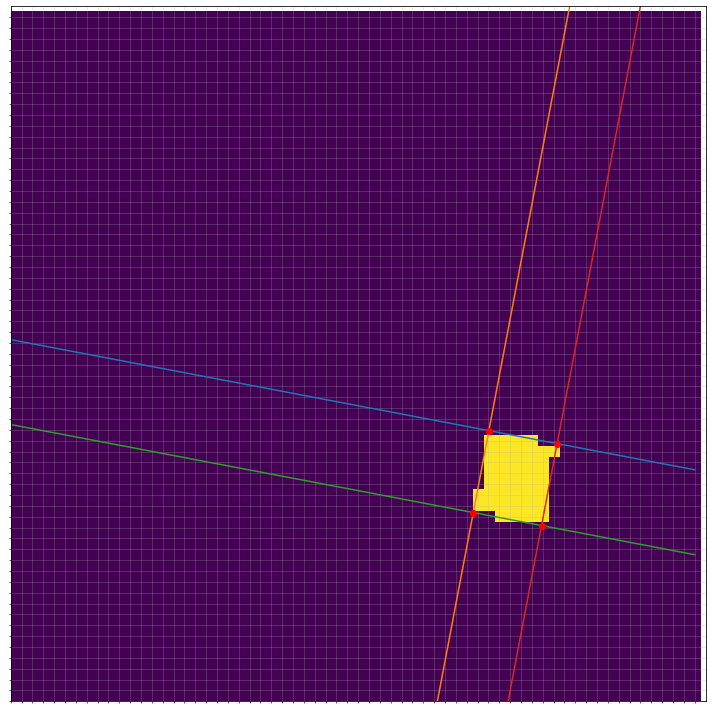

In [140]:
# plot an rectangle on the grid
room_size = 10
robot_size = 1
n = 64
w = robot_size * (n/room_size)
h = robot_size*1.2 * (n/room_size)
theta = np.random.random()*2*np.pi
# theta = 0.5

x_pos = random.random() * n
y_pos = random.random() * n

d = ((w/2)**2 + (h/2)**2)**0.5

# LINES (NOT USED FOR ACTUAL RASTERIZATION)
x = np.linspace(0, n-1, n)
y1 = -np.tan(theta)*(x-x_pos) + h/2 * 1/np.cos(theta) + y_pos
y2 = 1/np.tan(theta)*(x-x_pos) + w/2 * 1/np.sin(theta) + y_pos
y3 = -np.tan(theta)*(x-x_pos) - h/2 * 1/np.cos(theta) + y_pos
y4 = 1/np.tan(theta)*(x-x_pos) - w/2 * 1/np.sin(theta) + y_pos

# VERTICES (USED FOR RASTERIZATION)
p1 = [np.sin(np.arctan(w/h) + theta) * d + x_pos,
      np.cos(np.arctan(w/h) + theta) * d + y_pos]
p2 = [np.sin(np.pi - np.arctan(w/h) + theta) * d + x_pos,
      np.cos(np.pi - np.arctan(w/h) + theta) * d + y_pos]

p3 = [np.sin(np.pi + np.arctan(w/h) + theta) * d + x_pos,
      np.cos(np.pi + np.arctan(w/h) + theta) * d + y_pos]
p4 = [np.sin(-np.arctan(w/h) + theta) * d + x_pos,
      np.cos(-np.arctan(w/h) + theta) * d + y_pos]

robot = [p1, p2, p3, p4]

occ_grid = torch.zeros((n, n))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ticks = np.linspace(0, n-1, n)
ax.set_xticks(ticks, minor=True)
ax.set_yticks(ticks, minor=True)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.grid(which='minor', alpha=0.3)

ax.imshow(occ_grid)
for y in [y1, y2, y3, y4]:
    ax.plot(x, y)

for p in [p1, p2, p3, p4]:
    ax.plot(p[0], p[1], 'ro')

plt.xlim(0, n)
plt.ylim(0, n)
plt.tight_layout()

robot_state = walls = torch.tensor([[x_pos/n*room_size, y_pos/n*room_size, robot_size, 1.2*robot_size, theta]
                                    ]).unsqueeze(0).repeat(num_envs, 1, 1)
robot_vertices = torch.zeros(num_envs, 1, 4, 2)
rotated_robot_vertices = torch.zeros_like(robot_vertices)
robot_vertices, rotated_robot_vertices = get_vertices(
    robot_state, robot_vertices, rotated_robot_vertices)
robot_vertices = robot_vertices.view(num_envs, 1, 1, 1*4, 2)
rotated_robot_vertices = rotated_robot_vertices.view(
    num_envs, 1, 1, 1*4, 2)
Px = torch.tensor(list(range(n))).unsqueeze(
    dim=-1).unsqueeze(dim=-1).repeat(num_envs, 1, 1, 1*4)
Py = torch.transpose(Px, 1, 2)

out = get_occ_cells(Py, Px, robot_vertices, rotated_robot_vertices)
ax.imshow(out[0])


In [129]:
def edge_func(px, py, v1x, v1y, v2x, v2y):
    return ((px-v1x) * (v2y-v1y) - (py-v1y) * (v2x-v1x)) >= 0


def get_occ_cells(Px, Py, vertices, rotated_vertices):

    n = Py.shape[1]
    num_envs = Py.shape[0]

    b = vertices - rotated_vertices

    bx = b[:, :, :, :, 0]
    by = b[:, :, :, :, 1]
    vx = vertices[:, :, :, :, 0]
    vy = vertices[:, :, :, :, 1]

    Ax = torch.sub(Px, vx)
    Ay = torch.sub(Py, vy)

    left = torch.mul(Ax, by)
    right = torch.mul(Ay, bx)

    out = torch.where(left-right <= 0, torch.zeros_like(left),
                      torch.ones_like(left))

    mask = torch.zeros((num_envs, n, n))
    i = 0
    while i < out.shape[-1]:
        temp_mask = torch.ones((num_envs, n, n))
        for j in range(4):
            temp_mask = torch.mul(temp_mask, out[:, :, :, i+j])
        # overwrite to mask
        mask = torch.where(temp_mask != 0, torch.ones_like(mask), mask)
        i += 4

    return mask


num_envs = 3
num_walls = 4
Px = torch.tensor(list(range(n))).unsqueeze(dim=-1).repeat(1, 1, 4)
# Px = torch.tensor([np.linspace(0, n-1, n)]).unsqueeze(dim=-1).repeat(n, 1, 4)
Py = torch.transpose(Px, 0, 1)
# vertices = torch.tensor([p1, p2, p3, p4])


num_obj_vertices = 12
Px = torch.tensor(list(range(n))).unsqueeze(
    dim=-1).unsqueeze(dim=-1).repeat(num_envs, 1, 1, num_walls*4)
Py = torch.transpose(Px, 1, 2)

vertices = walls_vertices.view(num_envs, 1, 1, num_walls*4, 2)
rotated_walls_vertices = rotated_walls_vertices.view(
    num_envs, 1, 1, num_walls*4, 2)
# rotated_vertices = rotate_vertices(vertices)

print(Px.shape)
print(Py.shape)
print(vertices.shape)

out = get_occ_cells(Py, Px, vertices, rotated_walls_vertices)


torch.Size([3, 64, 1, 16])
torch.Size([3, 1, 64, 16])
torch.Size([3, 1, 1, 16, 2])


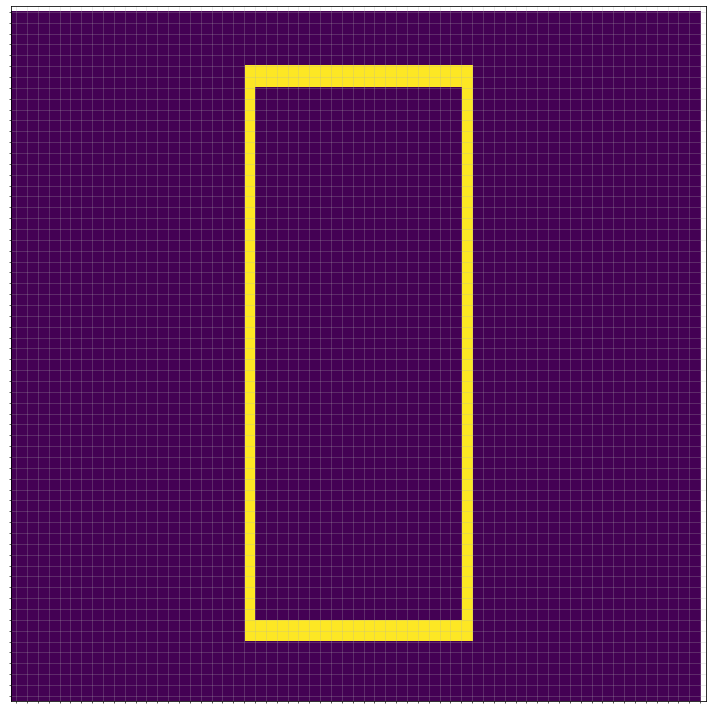

In [130]:
# plot rasterized rectangle
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ticks = np.linspace(0.5, n-0.5, n)
ax.set_xticks(ticks, minor=True)
ax.set_yticks(ticks, minor=True)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.grid(which='minor', alpha=0.3)

# ax.imshow(occ_grid)
ax.imshow(out[0])
# ax.imshow(out[0])

# for y in [y1, y2, y3, y4]:
#     ax.plot(x, y)
# for p in [p1, p2, p3, p4]:
#     ax.plot(p[0], p[1], 'ro')

plt.xlim(0, n)
plt.ylim(0, n)
plt.tight_layout()


In [206]:
occ_grid = torch.zeros_like(occ_grid)

for i in range(len(occ_grid)):
    for j in range(len(occ_grid[0])):
        inside = True
        for p in range(len(robot)):
            v0 = robot[p]
            v1 = robot[(p+1) % len(robot)]
            inside = inside and edge_func(
                j, i, v0[0], v0[1], v1[0], v1[1])
        if inside:
            occ_grid[i][j] = 1


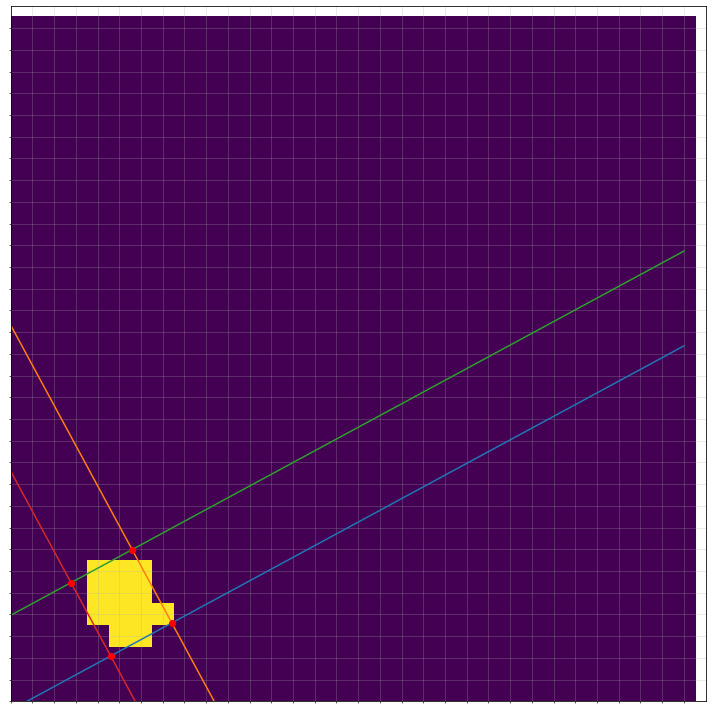

In [56]:
# plot rasterized rectangle
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ticks = np.linspace(0, n-1, n)
ax.set_xticks(ticks, minor=True)
ax.set_yticks(ticks, minor=True)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.grid(which='minor', alpha=0.3)

# ax.imshow(occ_grid)
ax.imshow(out)
for y in [y1, y2, y3, y4]:
    ax.plot(x, y)
for p in [p1, p2, p3, p4]:
    ax.plot(p[0], p[1], 'ro')

plt.xlim(0, n)
plt.ylim(0, n)
plt.tight_layout()


In [62]:
tensor_a = torch.zeros(3, 64, 1, 8)
tensor_b = torch.zeros(3, 1, 64, 8)

boxes = torch.ones(3, 1, 1, 8)

res = tensor_a - boxes

# res = tensor_a - tensor_b
res.shape


torch.Size([2, 64, 1, 4])